# Exercise 3: Multi-Class Classification with Synthetic Data and Reusable MLP

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import itertools

In [18]:
def sample_class_from_make_classification_multiclass(
    target_label: int,
    n_desired: int,
    n_classes: int,
    n_features: int,
    n_informative: int,
    n_clusters_per_class: int,
    class_sep: float,
    random_state: int,
):
    rng = np.random.RandomState(random_state)
    X_list, y_list = [], []
    total_collected = 0
    batch = max(900, n_desired * 2)
    while total_collected < n_desired:
        Xb, yb = make_classification(
            n_samples=batch,
            n_features=n_features,
            n_informative=n_informative,
            n_redundant=0,
            n_repeated=0,
            n_classes=n_classes,
            n_clusters_per_class=n_clusters_per_class,
            class_sep=1.6,
            flip_y=0.0,
            random_state=rng.randint(0, 10_000_000),
        )
        mask = (yb == target_label)
        X_keep, y_keep = Xb[mask], yb[mask]
        need = n_desired - total_collected
        if len(X_keep) > need:
            X_keep, y_keep = X_keep[:need], y_keep[:need]
        X_list.append(X_keep)
        y_list.append(y_keep)
        total_collected += len(X_keep)
    return np.vstack(X_list), np.concatenate(y_list)

In [19]:
n_per_class = 500
n_classes = 3
n_features = 4
X0, y0 = sample_class_from_make_classification_multiclass(0, n_per_class, 3, 4, 4, 2, 1.6, 42)
X1, y1 = sample_class_from_make_classification_multiclass(1, n_per_class, 3, 4, 4, 3, 1.6, 1337)
X2, y2 = sample_class_from_make_classification_multiclass(2, n_per_class, 3, 4, 4, 4, 1.6, 2025)
y0[:] = 0
y1[:] = 1
y2[:] = 2
X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])
rs = np.random.RandomState(111)
idx = rs.permutation(len(y))
X, y = X[idx], y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [20]:
class ScratchMLP:
    def __init__(self, input_dim=2, hidden_dim=8, lr=0.05, seed=0):
        rng = np.random.RandomState(seed)
        limit1 = np.sqrt(6 / (input_dim + hidden_dim))
        self.W1 = rng.uniform(-limit1, limit1, size=(input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))
        limit2 = np.sqrt(6 / (hidden_dim + 1))
        self.W2 = rng.uniform(-limit2, limit2, size=(hidden_dim, 1))
        self.b2 = np.zeros((1, 1))
        self.lr = lr

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_deriv(a):
        return 1.0 - a ** 2

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def bce_loss(y_true, y_prob, eps=1e-12):
        y_prob = np.clip(y_prob, eps, 1 - eps)
        return np.mean(-(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = self.tanh(z1)
        z2 = a1 @ self.W2 + self.b2
        yhat = self.sigmoid(z2)
        cache = (X, z1, a1, z2, yhat)
        return yhat, cache

    def backward(self, cache, y_true):
        X, z1, a1, z2, yhat = cache
        N = X.shape[0]
        y_true = y_true.reshape(-1, 1)
        dz2 = (yhat - y_true) / N
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.tanh_deriv(a1)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        return (dW1, db1, dW2, db2)

    def step(self, grads):
        dW1, db1, dW2, db2 = grads
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, y, epochs=200, verbose=False):
        history = []
        for ep in range(epochs):
            yhat, cache = self.forward(X)
            loss = self.bce_loss(y.reshape(-1, 1), yhat)
            history.append(loss)
            grads = self.backward(cache, y)
            self.step(grads)
        return history

    def predict_proba(self, X):
        yhat, _ = self.forward(X)
        return yhat.ravel()

In [21]:
# Train 3 OvA models
num_classes = 3
hidden_dim = 12
lr = 0.05
epochs = 200
models, histories = [], []
for k in range(num_classes):
    y_bin = (y_train == k).astype(np.float64)
    m = ScratchMLP(input_dim=n_features, hidden_dim=hidden_dim, lr=lr, seed=100+k)
    hist = m.fit(X_train, y_bin, epochs=epochs, verbose=False)
    models.append(m)
    histories.append(hist)

# Evaluate
probas = [m.predict_proba(X_test).reshape(-1,1) for m in models]
P = np.hstack(probas)
y_pred = np.argmax(P, axis=1)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Test accuracy (OvA MLP): {acc:.4f}")
print("Confusion matrix:\n", cm)

Test accuracy (OvA MLP): 0.5967
Confusion matrix:
 [[51 19 30]
 [25 63 12]
 [16 19 65]]


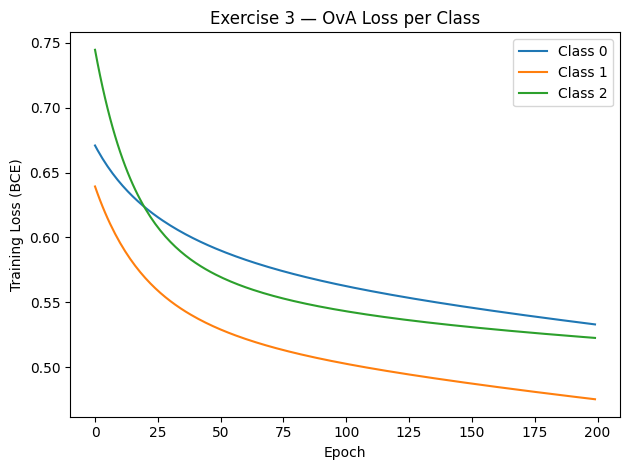

In [22]:
plt.figure()
for k, hist in enumerate(histories):
    plt.plot(np.arange(len(hist)), hist, label=f"Class {k}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (BCE)")
plt.title("Exercise 3 — OvA Loss per Class")
plt.legend() 
plt.tight_layout()
plt.show()

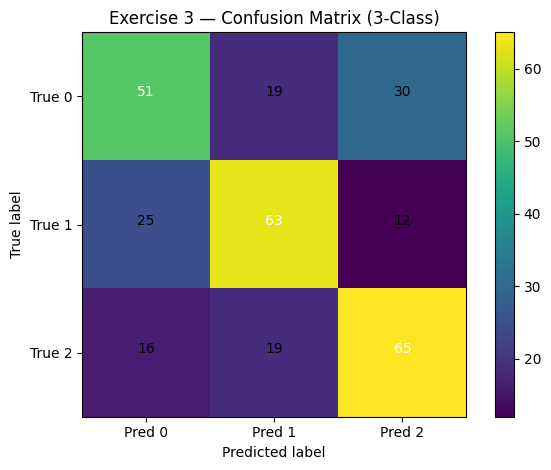

In [23]:
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Exercise 3 — Confusion Matrix (3-Class)"); plt.colorbar()
ticks = np.arange(3); plt.xticks(ticks, [f"Pred {i}" for i in range(3)])
plt.yticks(ticks, [f"True {i}" for i in range(3)])
th = cm.max()/2.0
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'),ha="center",color="white" if cm[i,j]>th else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

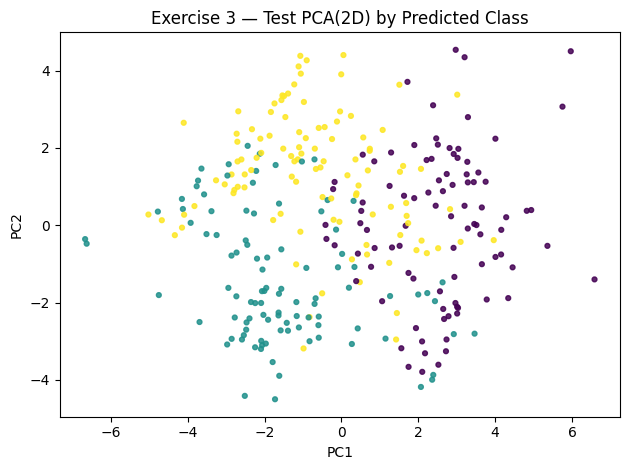

In [24]:
pca = PCA(n_components=2, random_state=0)
X2d = pca.fit_transform(X_test)
plt.figure()
plt.scatter(X2d[:,0], X2d[:,1], c=y_pred, s=12, alpha=0.85)
plt.title("Exercise 3 — Test PCA(2D) by Predicted Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()